In [1]:
from skimage import morphology,draw
import numpy as np
import matplotlib.pyplot as plt
import cv2

def readimage(t_name):
    image = cv2.imread(t_name,cv2.IMREAD_GRAYSCALE)
    ret,image=cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image=255-image

    #实施骨架算法
    skeleton =morphology.skeletonize(image)

    skeleton=255-skeleton
    image=255-image
    skeleton[skeleton!=255]=0
    return image,skeleton

In [2]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
def plotscatter(X_transformed):
    if X_transformed.shape[1]==3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_transformed[:num_fu,0],X_transformed[:num_fu,1],X_transformed[:num_fu,2],c="r",label="fu")
        ax.scatter(X_transformed[num_fu:num_fu+num_notfu,0],X_transformed[num_fu:num_fu+num_notfu,1],X_transformed[num_fu:num_fu+num_notfu,2],c="g",label="notfu")
        ax.scatter(X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,0],X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,1],X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,2],c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],X_transformed[-5:,1],X_transformed[-5:,2],c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

        plt.show()
    elif X_transformed.shape[1]==2:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(X_transformed[:num_fu,0],X_transformed[:num_fu,1],c="r",label="fu")
        ax.scatter(X_transformed[num_fu:num_fu+num_notfu,0],X_transformed[num_fu:num_fu+num_notfu,1],c="g",label="notfu")
        ax.scatter(X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,0],X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,1],c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],X_transformed[-5:,1],c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

        plt.show()
    elif X_transformed.shape[1]==1:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(X_transformed[:num_fu,0],0*np.ones(num_fu),c="r",label="fu")
        ax.scatter(X_transformed[num_fu:num_fu+num_notfu,0],1*np.ones(num_notfu),c="g",label="notfu")
        ax.scatter(X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,0],2*np.ones(5),c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],3*np.ones(5),c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

In [29]:
import os
import numpy as np
from sklearn.cluster import KMeans
from feature import feature


class BoW:
    def __init__(self, PathofData, dim=50, method="sift", data_dim=128) -> None:
        self.dim = dim
        self.method = method
        self.data_dim = data_dim
        data = np.empty([0, data_dim])
        for i in PathofData:
            if method in ["sift", "surf", "orb"]:
                feat = feature(i, method, show=False)[1]
            elif method == "shi-tomasi":
                feat = np.squeeze(feature(i, method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                data = np.concatenate((data, feat), axis=0)
        kmeans = KMeans(n_clusters=dim, random_state=0, n_init="auto").fit(data)
        self.kmeans = kmeans

    def fit(self, PathofData):
        N = len(PathofData)
        Word = np.zeros([N, self.dim])
        for index, i in enumerate(PathofData):
            if self.method in ["sift", "surf", "orb"]:
                feat = feature(i, self.method, show=False)[1]
            elif self.method == "shi-tomasi":
                feat = np.squeeze(feature(i, self.method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                label = self.kmeans.predict(feat.astype(float))
                hist, _ = np.histogram(label, bins=range(self.dim + 1))
            else:
                hist=np.zeros((1,self.dim))
            # if np.sum(hist)!=0:
            #     hist=hist/np.sum(hist)
            Word[index] = hist
        return Word
    
    def getSPM(self, PathofData,level):
        width = 500
        N = len(PathofData)
        Word = np.zeros([N, int(self.dim*(4**level-1)/3)])
        for index, i in enumerate(PathofData):
            counter=0
            for l in range(level):
                x,y=0,0
                step=np.floor(width/2**l).astype(int)
                for _ in range(2**l):
                    x=0
                    for _ in range(2**l):
                        if self.method in ["sift", "surf", "orb"]:
                            feat = feature(i, self.method, show=False,x_start=x,x_end=x+step,y_start=y,y_end=y+step)[1]
                        elif self.method == "shi-tomasi":
                            feat=feature(i, self.method, show=False,x_start=x,x_end=x+step,y_start=y,y_end=y+step)
                            if feat is not None:
                                feat = np.squeeze(feat,axis=1)
                        else:
                            print("no method. ")
                            return []
                        if feat is not None:
                            label = self.kmeans.predict(feat.astype(float))
                            hist, _ = np.histogram(label, bins=range(self.dim + 1))
                            weight = 2**(l-level)
                            hist=hist*weight
                        else:
                            hist=np.zeros((1,self.dim))
                        Word[index][counter*self.dim:(counter+1)*self.dim]=np.copy(hist)
                        counter+=1
                        x = x + step
                    y=y+step
        return Word

In [30]:
dim = 30
level=2
Features = [("sift", 128), ("surf", 64), ("orb", 32), ("shi-tomasi", 2)]
pathfu = "./traindata/fu/"
pathnotfu = "./traindata/not_fu/"
pathtest = "./testdata/"
num_fu=len(os.listdir(pathfu))
num_notfu=len(os.listdir(pathnotfu))
BOWfeat=np.zeros((num_fu+num_notfu+10, 0))
all=[pathfu + i for i in os.listdir(pathfu)]+[pathnotfu + i for i in os.listdir(pathnotfu)]+[pathtest + i for i in os.listdir(pathtest)]
for method, data_dim in Features:
    BoWfu = BoW(all,
        method=method,
        data_dim=data_dim,
        dim=dim,
    )
    BOWfeat = np.concatenate(
        (
            BOWfeat,
            BoWfu.fit(all),
        ),
        axis=1,
    )

In [31]:
data=BOWfeat

In [49]:
import os

from tqdm import tqdm

from feature import feature


pathfu = "./traindata/fu/"
pathnotfu = "./traindata/not_fu/"
pathtest = "./testdata/"

num_fu=len(os.listdir(pathfu))
num_notfu=len(os.listdir(pathnotfu))
num_test=len(os.listdir(pathtest))

data=np.zeros((num_fu+num_notfu+num_test,133956+250000))
y = np.concatenate((np.ones(num_fu), 0*np.ones(num_notfu),np.ones(5), 0*np.ones(5)))

all=[pathfu + i for i in os.listdir(pathfu)]+[pathnotfu + i for i in os.listdir(pathnotfu)]+[pathtest + i for i in os.listdir(pathtest)]
for index,i in enumerate(tqdm(all)):
    skeleton,_=readimage(i)
    skeleton=skeleton.flatten()
    skeleton=255-skeleton
    skeleton=skeleton/255
    hog=feature(i,"hog",False,skeleton=False).flatten()
    data[index]=np.concatenate((skeleton,hog))

100%|██████████| 1570/1570 [00:51<00:00, 30.70it/s]


In [50]:
data.shape,y.shape

((1570, 383956), (1570,))

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = LinearDiscriminantAnalysis()
clf.fit(data[:-10], y[:-10])
X=clf.transform(data)

In [9]:
from sklearn.manifold import MDS
embedding = MDS(n_components=3, normalized_stress='auto')
X = embedding.fit_transform(data)

In [51]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
embedding = make_pipeline(StandardScaler(),
                          LocallyLinearEmbedding(n_neighbors=10,
                                                 n_components=3,
                                                 method="modified",
                                                 eigen_solver='dense'))
X = embedding.fit_transform(data)
X.shape

(1570, 3)

In [38]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=2)
X = embedding.fit_transform(data)
X.shape

(1570, 2)

In [31]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2).fit_transform(data)
X.shape

(1570, 2)

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X=pca.fit_transform(data)

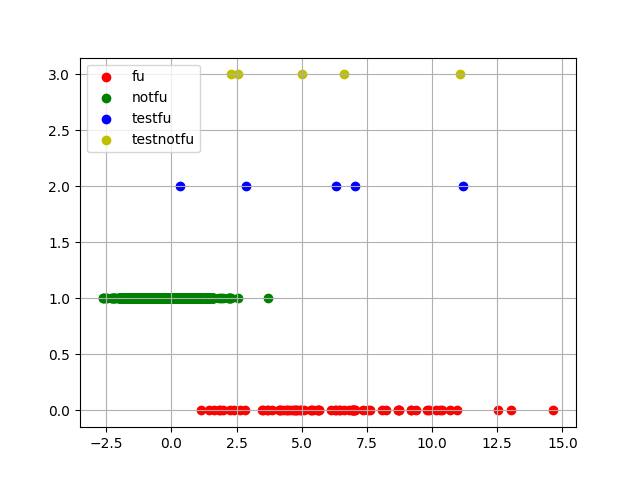

In [63]:
plotscatter(X)

In [54]:
data=np.concatenate((X,BOWfeat),axis=1)

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X[:-10,:], y[:-10], test_size=0.2, random_state=42
)
X_test=X[-10:,:]
y_test=y[-10:]

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(
    AdaBoostClassifier(n_estimators=50, random_state=0)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [69]:

from sklearn.metrics import f1_score
from hyperopt import hp
import xgboost as xgb

def train(args):
    learning_rate=args["learning_rate"]
    n_estimators=args["n_estimators"]
    eta=args["eta"]
    max_depth=args["max_depth"]
    subsample=args["subsample"]
    colsample_bytree=args["colsample_bytree"]
    min_child_weight=args["min_child_weight"]
    reg_alpha=args["reg_alpha"]
    reg_lambda=args["reg_lambda"]

    model = xgb.XGBClassifier(learning_rate=learning_rate,n_estimators=n_estimators,eta=eta,
                              max_depth=max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
                              min_child_weight=min_child_weight,reg_alpha=reg_alpha,reg_lambda=reg_lambda)
    model.fit(X_train, y_train)
    return model

def objective(args):
    model=train(args)
    y_pred=model.predict(X_val)
    f1=f1_score(y_val,y_pred,average="macro")
    return -f1

space={"learning_rate":hp.choice("learning_rate", [0.1]),
    "n_estimators":hp.choice("n_estimators",[50, 100, 150, 200, 300]), # 多少棵树
    "eta": hp.choice("eta",[0.05, 0.1, 0, 2, 0.3]),  # 学习率
    "max_depth": hp.choice("max_depth",range(2, 15, 1)),  # 树的最大深度
    "subsample": hp.uniform("subsample", 0.7, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.98),  # 选择多少列构建一个树
    "min_child_weight": hp.choice("min_child_weight",range(1, 9, 1)),  # 叶子节点最小样本数目
    "reg_alpha": hp.choice("reg_alpha",[0, 0.01, 0.02, 0.05, 0.7, 0.1, 1]),
    "reg_lambda": hp.choice("reg_lambda",[0, 0.1, 0.5, 1])}

from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=500)
print(best)
print(space_eval(space, best))
clf=train(space_eval(space, best))

100%|██████████| 500/500 [01:18<00:00,  6.39trial/s, best loss: -0.925215723873442]
{'colsample_bytree': 0.6132524225971493, 'eta': 3, 'learning_rate': 0, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 0, 'reg_alpha': 3, 'reg_lambda': 1, 'subsample': 0.8399666712003534}
{'colsample_bytree': 0.6132524225971493, 'eta': 2, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 50, 'reg_alpha': 0.05, 'reg_lambda': 0.1, 'subsample': 0.8399666712003534}


In [70]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_val)
print(f1_score(y_val, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

0.925215723873442


array([[296,   0],
       [  4,  12]])

In [71]:
y_pred = clf.predict(X_test)
print(y_pred)
print(f1_score(y_test,y_pred, average="macro"))
print(confusion_matrix(y_pred, y_test))

[0 0 1 0 1 0 0 1 1 1]
0.4000000000000001
[[2 3]
 [3 2]]
